In [1]:
from methods.ensemble import Ensemble
from methods.mc_droput import NeuralNetworkWithDropout
from methods.bnn_bpp import *
from methods.sghmc import *
from utils.data import get_dataloader
import torch
import matplotlib.pyplot as plt
import numpy as np

Target 1D function

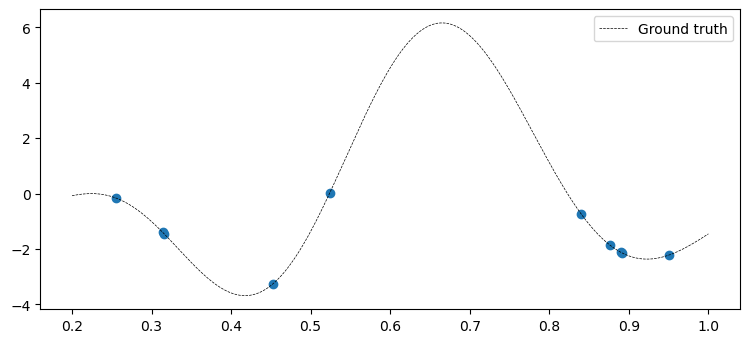

In [10]:
def function(x):
    return -(torch.sin(x*7)+torch.cos(14*x))*(x**2)*torch.exp(-4*x)*100

#range for sampling
xmin=0.2
xmax=1.00
points_plot=1000                              #resolution to plot the ground truth 
x_plot=torch.linspace(xmin, xmax, points_plot) 
y_plot=function(x_plot)

training_samples = 10                   
x_data=np.random.uniform(xmin, xmax, training_samples)
x_data = torch.from_numpy(x_data.astype(np.float32)).view(-1,1)
y_data=function(x_data)


fig = plt.figure(figsize=(7,3))
ax=fig.add_axes([0,0,1,1])
ax.plot(x_plot, y_plot,label=r"Ground truth",linestyle='dashed',linewidth=0.5,color='k')
ax.scatter(x_data.cpu().detach().numpy(), y_data.cpu().detach().numpy())
plt.legend(prop={'size': 10})

BNN model with BPP

In [53]:
# Example usage
input_size = 1
hidden_sizes = 30
output_size = 1

bnn_bpp = BNN_BPP(input_size, hidden_sizes, output_size)
print(bnn_bpp), bnn_bpp.count_parameters(bnn_bpp)

BNN_BPP(
  (fc_mu_1): BayesianLayer()
  (fc_mu_2): BayesianLayer()
)


(None, 124)

In [54]:
train_loader_1, _ = get_dataloader(x_data, y_data, 1, 1, train_test_split=1.0, batch_size=10)

# x_batch,y_batch = next(iter(train_loader))
# x_batch.shape, y_batch.shape

bnn_bpp.train(train_loader_1, num_epochs=10000, lr=1e-3, verbose=1, kl_scale=10)

Epoch [1/10000], Loss MSE: 2.069643259048462, Loss KL: 25.810882568359375
Epoch [2/10000], Loss MSE: 2.005326509475708, Loss KL: 25.803253173828125
Epoch [3/10000], Loss MSE: 1.9743106365203857, Loss KL: 25.79562759399414
Epoch [4/10000], Loss MSE: 1.92330801486969, Loss KL: 25.788021087646484
Epoch [5/10000], Loss MSE: 1.9261068105697632, Loss KL: 25.78042221069336
Epoch [6/10000], Loss MSE: 1.8697843551635742, Loss KL: 25.7728271484375
Epoch [7/10000], Loss MSE: 1.8247582912445068, Loss KL: 25.765243530273438
Epoch [8/10000], Loss MSE: 1.804602026939392, Loss KL: 25.75766944885254
Epoch [9/10000], Loss MSE: 1.7816505432128906, Loss KL: 25.750106811523438
Epoch [10/10000], Loss MSE: 1.736437439918518, Loss KL: 25.742549896240234
Epoch [11/10000], Loss MSE: 1.7425553798675537, Loss KL: 25.734996795654297
Epoch [12/10000], Loss MSE: 1.6769037246704102, Loss KL: 25.72745704650879
Epoch [13/10000], Loss MSE: 1.6835826635360718, Loss KL: 25.719921112060547
Epoch [14/10000], Loss MSE: 1.626

BNN with SGHMC

In [55]:
#network config
width, layers = 20, 1
use_cuda = torch.cuda.is_available()

burn_in = 50   #How many epochs to burn in for?. Default: 20.
sim_steps = 2   #How many epochs pass between saving samples. Default: 2.
N_saves=20
resample_its = 50
resample_prior_its = 15
re_burn = 1e8
n_passive_ep = 5000

net_hmc = BNN_SGHMC(N_train=training_samples, input_dim=input_size, width=width, depth=layers, output_dim=output_size, 
                lr=1e-2, cuda=use_cuda, grad_std_mul=10)

In [56]:
train_loader_2, _ = get_dataloader(x_data, y_data, 1, 1, train_test_split=1.0, batch_size=10)

net_hmc.train(train_loader_2, epoch=n_passive_ep, burn_in=burn_in, re_burn = re_burn , 
                resample_its=resample_its, resample_prior_its = resample_prior_its, 
                sim_steps = sim_steps, N_saves=N_saves, verbose=1)

it 0/5000, train_loss = 3.635002,
it 1/5000, train_loss = 3.622080,
it 2/5000, train_loss = 3.606170,
it 3/5000, train_loss = 3.591728,
it 4/5000, train_loss = 3.576245,
it 5/5000, train_loss = 3.564496,
it 6/5000, train_loss = 3.557612,
it 7/5000, train_loss = 3.553630,
it 8/5000, train_loss = 3.550156,
it 9/5000, train_loss = 3.572672,
it 10/5000, train_loss = 3.600065,
it 11/5000, train_loss = 3.628465,
it 12/5000, train_loss = 3.649905,
it 13/5000, train_loss = 3.670688,
it 14/5000, train_loss = 3.698633,
it 15/5000, train_loss = 3.722395,
it 16/5000, train_loss = 3.745255,
it 17/5000, train_loss = 3.760750,
it 18/5000, train_loss = 3.799062,
it 19/5000, train_loss = 3.841561,
it 20/5000, train_loss = 3.875408,
it 21/5000, train_loss = 3.911982,
it 22/5000, train_loss = 3.944550,
it 23/5000, train_loss = 3.975256,
it 24/5000, train_loss = 4.010617,
it 25/5000, train_loss = 4.039975,
it 26/5000, train_loss = 4.069850,
it 27/5000, train_loss = 3.986640,
it 28/5000, train_loss = 3.840

BNN with Droput

In [58]:
# Neural net config
net_dropout = NeuralNetworkWithDropout(input_size=1, hidden_size=50, output_size=1, dropout_prob=0.1)

In [59]:
train_loader_3, _ = get_dataloader(x_data, y_data, 1, 1, train_test_split=1.0, batch_size=10)
net_dropout.train(train_loader_3, num_epochs=20000, learning_rate=1e-4, verbose=1)

Epoch [1/20000], Loss: 1.766689658164978
Epoch [2/20000], Loss: 3.5452728271484375
Epoch [3/20000], Loss: 3.6413938999176025
Epoch [4/20000], Loss: 0.03733731433749199
Epoch [5/20000], Loss: 0.019017305225133896
Epoch [6/20000], Loss: 3.895099401473999
Epoch [7/20000], Loss: 2.4110605716705322
Epoch [8/20000], Loss: 1.6077747344970703
Epoch [9/20000], Loss: 9.4010009765625
Epoch [10/20000], Loss: 0.0014385523973032832
Epoch [11/20000], Loss: 1.120242714881897
Epoch [12/20000], Loss: 0.026783568784594536
Epoch [13/20000], Loss: 0.35588711500167847
Epoch [14/20000], Loss: 9.072587013244629
Epoch [15/20000], Loss: 2.3870790004730225
Epoch [16/20000], Loss: 1.4945778846740723
Epoch [17/20000], Loss: 1.971547245979309
Epoch [18/20000], Loss: 2.092198371887207
Epoch [19/20000], Loss: 3.0176758766174316
Epoch [20/20000], Loss: 2.622868776321411
Epoch [21/20000], Loss: 0.07628940045833588
Epoch [22/20000], Loss: 3.5110230445861816
Epoch [23/20000], Loss: 3.063795328140259
Epoch [24/20000], Los

Ensembles BNN

In [60]:
# Neural net config
net_ensemble = Ensemble(input_size=1, hidden_size=30, output_size=1, num_models=3)

In [61]:
train_loader_4, _ = get_dataloader(x_data, y_data, 1, 1, train_test_split=1.0, batch_size=3)
net_ensemble.train_ensemble(train_loader_4, num_epochs=10000, verbose=1)

Epoch [1/10000], Loss: 3.8068666458129883
Epoch [2/10000], Loss: 2.1229634284973145
Epoch [3/10000], Loss: 0.021304983645677567
Epoch [4/10000], Loss: 1.907352089881897
Epoch [5/10000], Loss: 3.1029868125915527
Epoch [6/10000], Loss: 2.1367053985595703
Epoch [7/10000], Loss: 0.000145899728522636
Epoch [8/10000], Loss: 2.6316933631896973
Epoch [9/10000], Loss: 2.48992657661438
Epoch [10/10000], Loss: 0.028210997581481934
Epoch [11/10000], Loss: 0.21045039594173431
Epoch [12/10000], Loss: 7.920101165771484
Epoch [13/10000], Loss: 1.9760655164718628
Epoch [14/10000], Loss: 7.526512145996094
Epoch [15/10000], Loss: 0.0015831044875085354
Epoch [16/10000], Loss: 1.060927152633667
Epoch [17/10000], Loss: 0.014199957251548767
Epoch [18/10000], Loss: 0.8207065463066101
Epoch [19/10000], Loss: 1.4025375843048096
Epoch [20/10000], Loss: 0.5833581686019897
Epoch [21/10000], Loss: 1.2010149955749512
Epoch [22/10000], Loss: 0.21833555400371552
Epoch [23/10000], Loss: 1.096198320388794
Epoch [24/1000

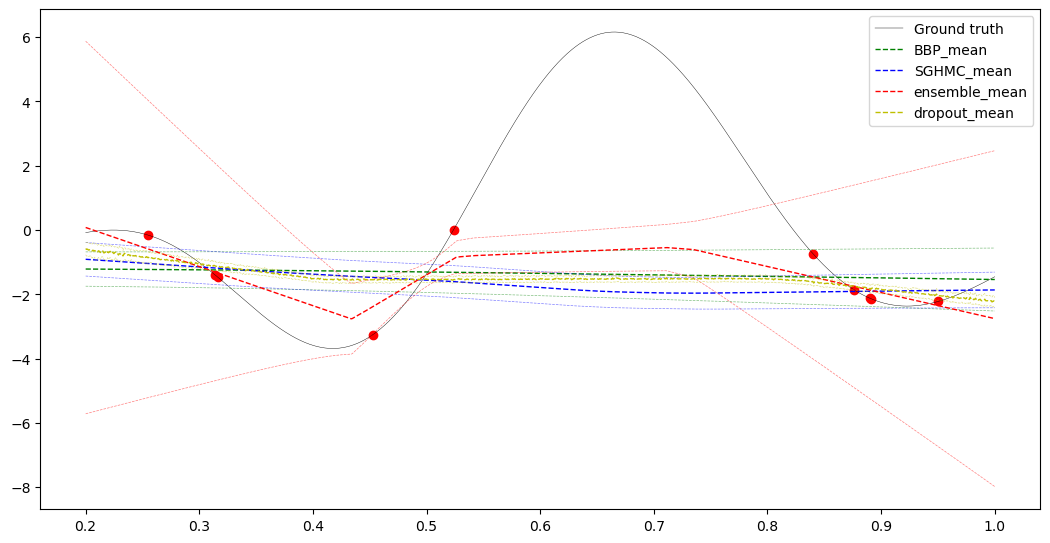

In [62]:
#range for plotting
points_test=1000                             
x_plot=torch.linspace(xmin, xmax, points_test).view(points_test,-1)
y_plot=function(x_plot)

n_sim = 100
bnn_pred = bnn_bpp.predictive_uq(x_plot, n_sim)
bnn_mean = bnn_pred.mean(dim=1)
bnn_std = bnn_pred.std(dim=1)

hmc_pred = net_hmc.sample_predict(x_plot, Nsamples=N_saves)
hmc_mean = torch.mean(hmc_pred, 0)
hmc_std = torch.std(hmc_pred, 0)

Y_uq_drop = net_dropout.predictive_uq(x_plot, 100)
drop_mean = Y_uq_drop.mean(dim=1)
drop_std = Y_uq_drop.std(dim=1)

Y_uq_ensemble = net_ensemble.predictive_uq(x_plot)
ensemble_mean = Y_uq_ensemble.mean(dim=1)
ensemble_std = Y_uq_ensemble.std(dim=1)

fig = plt.figure(figsize=(10,5))
ax=fig.add_axes([0,0,1,1])
ax.plot(x_plot, y_plot,label=r"Ground truth",linestyle='-',linewidth=0.3,color='k')

#BNN by bayes bp
ax.plot(x_plot, bnn_mean,label=r"BBP_mean",linestyle='dashed',linewidth=1.0,color='g')
ax.plot(x_plot, bnn_mean+bnn_std,linestyle='dashed',linewidth=0.5,color='g', alpha=0.5)
ax.plot(x_plot, bnn_mean-bnn_std,linestyle='dashed',linewidth=0.5,color='g', alpha=0.5)

#BNN by SGHMC
ax.plot(x_plot, hmc_mean,label=r"SGHMC_mean",linestyle='dashed',linewidth=1.0,color='b')
ax.plot(x_plot, hmc_mean+hmc_std,linestyle='dashed',linewidth=0.5,color='b', alpha=0.5)
ax.plot(x_plot, hmc_mean-hmc_std,linestyle='dashed',linewidth=0.5,color='b', alpha=0.5)

#ensembles
ax.plot(x_plot, ensemble_mean,label=r"ensemble_mean",linestyle='dashed',linewidth=1.0,color='r')
ax.plot(x_plot, ensemble_mean+ensemble_std,linestyle='dashed',linewidth=0.5,color='r', alpha=0.5)
ax.plot(x_plot, ensemble_mean-ensemble_std,linestyle='dashed',linewidth=0.5,color='r', alpha=0.5)

#Dropout
ax.plot(x_plot, drop_mean,label=r"dropout_mean",linestyle='dashed',linewidth=1.0,color='y')
ax.plot(x_plot, drop_mean+drop_std,linestyle='dashed',linewidth=0.5,color='y', alpha=0.5)
ax.plot(x_plot, drop_mean-drop_std,linestyle='dashed',linewidth=0.5,color='y', alpha=0.5)

ax.scatter(x_data.cpu().detach().numpy(), y_data.cpu().detach().numpy(), color='r')

ax.legend()